In [7]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from ..torch_DE.continuous.DE_module import DE_Getter
from ..torch_DE.continuous.Networks import *


def MSE(x:torch.tensor):
    return x.pow(2).mean()




SyntaxError: invalid syntax (3614708888.py, line 4)

# Spring Equation

For our first example lets solve a simple ODE $$ \dfrac{d^2u}{dt^2} = -u(t) ,\quad 0 \leq u \leq 2\pi $$ with initial conditions $u(0)=0$ and $\dfrac{du}{dt} = 1$. This is the famous spring equation and has the solution: $$u(t) = sin(t)$$.

Suppose we don't know the actual solution (in more complicated equations we really don't know!) but know the ODE. Then we want to create and train a network $u_{net}(t)$ that can approximate $u(t)$
$$u_{net}(t)\approx u(t)$$ 
For Torch DE, we need to define 3 things: set up the DE_getter object, generate the some data points and finally create the training loop. If you are familar with pytorch, you'll notice that all of the syntax is very familiar!

## Data Generation

So first thing to do is to generate the data, For this example we can simply generate a 1000 random points between 0 and  $2\pi$. We also need to specifically create a point at t = 0. In this example the initial conditions serve to act as our 'data' while all the other points are called collocation points. Collocation points are points where we don't have any data for but expect to follow a certain equation (in this case we expect these point to follow the above spring equation)

In [3]:
# Collocation Points (From 0 to 2pi)
t_col = torch.rand((998,1))*2*torch.pi

# Initial conditions u(0) = 0 , u_t(0) = 1
t_data = torch.tensor([0]).unsqueeze(-1)

t = torch.cat([t_data,t_col])

print(t.shape)

torch.Size([999, 1])


## Network Creation and DE_Getter

For this simple model, we'll just use a one hidden layer network with a tanh function. ReLu won't work here as well be needing the second derivative (second derivative of Relu is 0 everywhere)

Next we can set up the DE Getter. All we need to do is to choose the variable names of our input and outputs and the derivatives to call. The derivatives use the subscript notation with the underscore indicating the subscript. For example the string 'u_tt' is requesting the second derivative of u with respect to t

u_tt $\equiv u_{tt} \equiv \dfrac{d^2u}{dt^2} $


Note that currently input varibles can only be single characters.

In [ ]:
net = nn.Sequential(nn.Linear(1,200),nn.Tanh(),nn.Linear(200,1))
# Spring Equation

PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['t'], output_vars= ['u'])
PINN.set_derivatives(derivatives=['u_t','u_tt'])



## Training Loop
If you have used Pytorch before, youll notice that the training loop looks very similar! The big difference is that instead of calling the network, we call the DE_Getter.calculate method. This will extract all the derivatives for us and put it into a nice dictionary format so we can easily access the derivatives. If we didn't, then we'd be doing some annoying indexing method

For PINN training theres 2 types of losses to be calculated. The first is the data fitting. This is fitting the network to any sort of data, initial condition or boundary conditions. We use the standard Mean Square error to fit these known points
$$Loss_{data} = \sum_i^M (u_{net}(t_i) - u_{data}(t_i))^2 + \sum_i^N \biggl[\dfrac{du_{net}}{dt_i} - \dfrac{du_{data}}{dt_i}\biggr]^2 $$

The second loss is the equation itself. Moving eveything to the left hand side:
$$\dfrac{d^2u}{dt^2}+u(t) = 0 $$

Ideally, when we calculate the above with our network $u_{net}$ the above equation is close to 0, however intially this is not the case and the LHS is some non zero function:
$$\dfrac{d^2u_{net}}{dt^2}+u_{net}(t) = R(t) $$ 

We call R(t) the residual function. We want to minimise this value, as this will mean that our network is then following this equation correctly in our domain. Minimisation is also done with mean square error
$$Loss_{Reisdual} = \sum_i^n (\dfrac{d^2u_{net}}{dt_i^2}+u_{net}(t_i))^2 $$

So the total Loss is:
$$Loss = Loss_{data} + Loss_{Residual}$$


For the optimizer well use Adam and a lr of 1e-3 and train for 5000 Epochs. Don't worry this run in a few min on just the CPU!

In [ ]:
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)

# For Loop
for i in range(5000):
    #Calculate Derivatives
    out = PINN.calculate(t)

    #Spring Equation is u_tt + u = 0. Notice we can easily call derivatives and outputs by strings rather than having to do
    #indexing
    residual = (out['u_tt'] + out['u']).pow(2).mean()

    #Data Fitting. In this case we know that the first element is the point t=0
    data = out['u'][0].pow(2).mean() + (out['u_t'][0] - 1).pow(2).mean()


    loss = data + residual
    print(f'Epoch {i} Total Loss{float(loss)}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Plotting Spring Equation

We can then plot the results and compare with the analytical solution.

In [4]:
from matplotlib import pyplot as plt

def torch_line_plot(x:torch.tensor,y:torch.tensor,*args,return_vars:bool=False,plot_func:bool = True ,**kwargs):
    '''
    Just a more convient way of plotting using matplotlib ploting function for Pytorch networks
    
    x = input to network. torch.tensor of shape (B,1) where B is batch size.
    y = output of network.  torch.tensor of shape (B,1) where B is batch size.
    return_vars: Whether to return the cleaned x and y for further plotting, Default False
    plot_func: Whether to plot the function of (x,y(x)), Default True

    *args and **kwargs are any parameters to pass into matplotlib.pyplot's plot function
    '''

    x_in = x.to('cpu').squeeze().detach().numpy()
    y_in = y.to('cpu').squeeze().detach().numpy()

    print(x_in.shape,y_in.shape)
    if plot_func:
        plt.plot(x_in,y_in,*args,**kwargs)

    if return_vars is True:
        return x_in,y_in

torch.Size([100, 1]) torch.Size([100, 1])
(100,) (100,)
(100,) (100,)


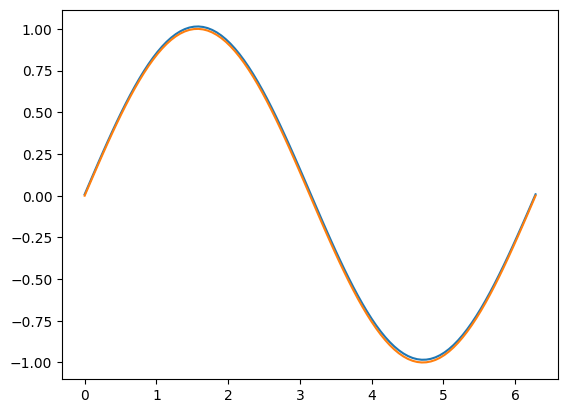

In [67]:
from matplotlib import pyplot as plt


x = torch.linspace(0,2*torch.pi,100).unsqueeze(dim = -1)
y = net(x)

y_pred = torch.sin(x)
print(x.shape,y.shape)
torch_line_plot(x,y)
torch_line_plot(x,y_pred)

Looks pretty good right!

# 1D Heat Equation
Lets move on to something a bit more difficult the Heat equation. This is a partial differential equation (PDE) as the heat u depends on both space and time.
$$$$

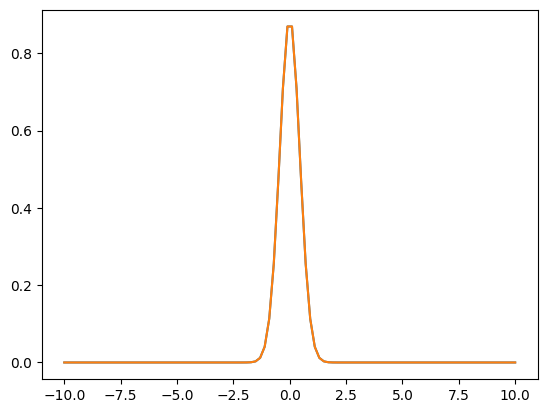

In [21]:
#Heat Equation
#Thermal Diffusivity
k = 1

# x points
x = torch.linspace(-10,10,100)
t = torch.linspace(0.1,10,50)

#Generate all (x,t) points above this is |x|*|t| number of points so 100**2 = 10,000 points

x_g,t_g = torch.meshgrid([x,t])

#Flatten the grid into a single line tensor and then stack to form a [10000,2] tensor

x_f,t_f = x_g.flatten(),t_g.flatten()

points = torch.stack([x_f,t_f],dim = -1)

#Initial Conditions is at t= 0.1
IC_x = points[points[:,-1] == t[0]][:,0]
IC = 1/torch.sqrt(4*torch.pi*k*t[0])*torch.exp(-IC_x**2 /(4*k*t[0]))

#Show IC solution (No extra dims so can use normal plt.plot)
plt.plot(x,IC)
norm = lambda x,t : 1/torch.sqrt(4*torch.pi*k*t)*torch.exp(-x**2/(4*k*t))

plt.plot(x,norm(x,torch.tensor([0.1])))

In [11]:

device = 'cpu'
net = nn.Sequential(nn.Linear(2,200),nn.Tanh(),nn.Linear(200,1))

PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['x','t'], output_vars= ['u'])
PINN.set_derivatives(derivatives=['u_t','u_xx'])


optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
net = net.to(device=device)
# For Loop
for i in range(10000):
    out = PINN.calculate(points.to(device))
    #Spring Equation is u_tt + u = 0
    residual = (k*out['u_xx'] - out['u_t']).pow(2).mean()

    #Data Fitting or in this case IC
    data = (out['u'][points[:,-1] == t[0]] - IC.to(device)).pow(2).mean()

    loss = data + residual
    print(f'Epoch {i} Total Loss{float(loss)}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 Total Loss0.15102127194404602
Epoch 1 Total Loss0.08443997800350189
Epoch 2 Total Loss0.06459305435419083
Epoch 3 Total Loss0.07230255752801895
Epoch 4 Total Loss0.07947544753551483
Epoch 5 Total Loss0.07481079548597336
Epoch 6 Total Loss0.062062330543994904
Epoch 7 Total Loss0.04848145693540573
Epoch 8 Total Loss0.03947000950574875
Epoch 9 Total Loss0.03681806102395058
Epoch 10 Total Loss0.03864830732345581
Epoch 11 Total Loss0.04113152250647545
Epoch 12 Total Loss0.04121427237987518
Epoch 13 Total Loss0.03825676068663597
Epoch 14 Total Loss0.03369585797190666
Epoch 15 Total Loss0.029688149690628052
Epoch 16 Total Loss0.027800990268588066
Epoch 17 Total Loss0.028263654559850693
Epoch 18 Total Loss0.03000842221081257
Epoch 19 Total Loss0.03145362436771393
Epoch 20 Total Loss0.03151015564799309
Epoch 21 Total Loss0.03012021817266941
Epoch 22 Total Loss0.02807609736919403
Epoch 23 Total Loss0.026397360488772392
Epoch 24 Total Loss0.02570393495261669
Epoch 25 Total Loss0.025913605

In [13]:
torch.save(net.state_dict(),'net_weights.pth')

In [3]:
net = nn.Sequential(nn.Linear(2,200),nn.Tanh(),nn.Linear(200,1))
net.load_state_dict(torch.load('net_weights.pth'))

<All keys matched successfully>

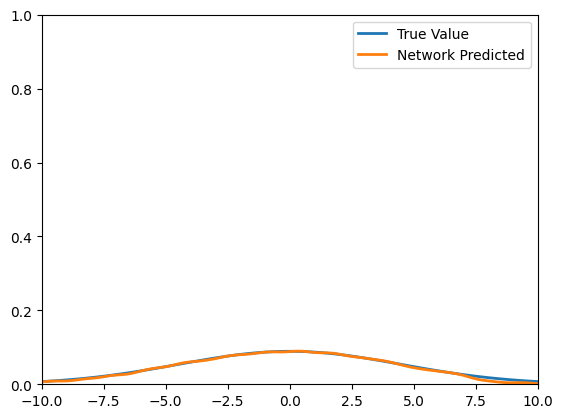

In [23]:
from torch import tensor
import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig = plt.figure()
axis = plt.axes(xlim =(-10, 10),
				ylim =(0, 1))

line, = axis.plot([], [], lw = 2,label = 'True Value')
line2, = axis.plot([], [], lw = 2,label = 'Network Predicted')
k=1

def init():
	line.set_data([], [])
	return line,

# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []
norm = lambda x,t : 1/torch.sqrt(4*torch.pi*k*t)*torch.exp(-x**2/(4*k*t))


plt.legend()
# animation function
def animate(i):
    x = torch.linspace(-10, 10, 100)
    t = tensor([i*0.1 + 0.1])
    y_true = norm(x,t)  # Update the y-values based on the frame number
    
    t_net = torch.ones_like(x)*t

    points = torch.stack([x,t_net],dim = -1)
    y_pred = net(points)

    line.set_data(x,y_true)
    line2.set_data(x,y_pred.detach().squeeze())
    return (line,line2)
	

# calling the animation function	
anim = animation.FuncAnimation(fig, animate,
							init_func = init,
							frames = 100,
							interval = 20,
							blit = True)

# saves the animation in our desktop
anim.save('Heat_Equation.mp4', writer = 'ffmpeg', fps = 10)